# Iteration 9: Summary

This iteration produced one of my best results. The only configuration I changed from the previous iteration was decreasing the learning rate to 0.001.

Test results:

Accuracy 0.75
Loss 0.61

I also included the results of testing on a group of 25 images (5 per class), which my team will use to compare correctly classified and misclassified images between our 3 algorithms.

import shutil
import os

source = './food-101/test/ramen'
dest = './food-101/valid/ramen'

files = os.listdir(source)

i = 0
for f in files:
    if i < 175:
        file= os.path.join(source, f)
        shutil.move(file,dest)
        print("adding img ", i)
    i+=1

# Preprocessing and Loading Data

For loading the data, I first used the train/test split that was provided with our dataset.  This gave us 750 images in train and 250 in test PER CLASS.  Then, I split the test set into test & validation.  I moved 175 images to the validation set, thus we are left with 75 images in test.

For image preprocessing, I first resize each image to our IMG_SIZE constant, currently set to 224 pixels.  I then recolor the image to RGB.  I also assign the labels to the images and shuffle the dataset.


After loading the data, the shape of X (features) will be (-1 {this means any number of features}, IMG_SIZE, IMG_SIZE, 3 {number of channels - RGB}), and the shape of y (labels) will be (-1, 1).

In [1]:
# importing necessary libraries
import numpy as np
import matplotlib.pyplot as plt

import os
from os import listdir
from os.path import isfile, join

import cv2
import random
import datetime
import time
import shutil
import stat

import collections
from collections import defaultdict

import tensorflow as tf
from tensorflow.keras import optimizers
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Input, Dense, Dropout, Activation, Flatten, Conv2D, MaxPooling2D
from tensorflow.keras.callbacks import TensorBoard
from tensorflow.keras.utils import to_categorical, plot_model

from keras.models import Model

Using TensorFlow backend.


In [2]:
# constants
IMG_SIZE = 224
NUM_CLASSES = 5
noodle_classes = ['pad_thai','pho','ramen','spaghetti_bolognese','spaghetti_carbonara']

# these are the main variables we tested and documented
EPOCHS = 40
BATCH_SZ = 64
LEARN_RATE = 0.001

In [3]:
# function to create the datasets (train, test, and valid)
# preprocesses the images (resize/recolor), assigns labels, and shuffles the dataset
root_dir = 'food-101/images/'

def create_data(root, _name):
    data_set = []

    for noodle_class in noodle_classes:
        path = os.path.join(root, noodle_class)
        label = noodle_classes.index(noodle_class) # assign an integer label to the image based on our noodle_classes array
        print(noodle_class,label)

        for img in os.listdir(path): # iterates through each image in the noodle folder
                if img.startswith('.'):
                    continue
                # each image is a 2D array of RGB value
                try:
                    img_arr = cv2.imread(os.path.join(path,img)) 
                    img_to_rgb = img_arr[:,:,::-1] # recolor
                    new_img = cv2.resize(img_to_rgb,(IMG_SIZE,IMG_SIZE)) #resize
                    data_set.append([new_img,label]) # store image and label together in dataset so we can shuffle without images getting mislabeled
                except Exception as e: # catch bad images
                    print("create exception: ",e)
        
    # randomize
    random.shuffle(data_set)
    
    X = []
    y = []

    for features, label in data_set:
        X.append(features) # 2D array of RGB values representing features
        y.append(label) # integer representing class/label

    # reshape X and y
    X = np.array(X).reshape(-1, IMG_SIZE, IMG_SIZE, 3)
    y = np.array(y).reshape(-1, 1)
    print('X', X.shape)
    print('y', y.shape)

    return X,y

In [4]:
# load data in train, test, and valid

X_train, y_train = create_data('food-101/train', "train")
X_test, y_test = create_data('food-101/test', "test")
X_valid, y_valid = create_data('food-101/valid', "valid")

pad_thai 0
pho 1
ramen 2
spaghetti_bolognese 3
spaghetti_carbonara 4
X (3750, 224, 224, 3)
y (3750, 1)
pad_thai 0
pho 1
ramen 2
spaghetti_bolognese 3
spaghetti_carbonara 4
X (375, 224, 224, 3)
y (375, 1)
pad_thai 0
pho 1
ramen 2
spaghetti_bolognese 3
spaghetti_carbonara 4
X (875, 224, 224, 3)
y (875, 1)


# Data Normalization and Augmentation
Here I am normalizing the data to scale our input training vectors. This will help improve accuracy and increase training speed.

Currently, I am attempting to implement image augmentation to improve accuracy as well.

In [5]:
# normalize data
# X_train = X_train/255.0
# X_test = X_test/255.0

#print('X train before normalize',X_train[1])
print('y train before normal',y_train)
# input('wait1')

# L2-normalizes the given array, i.e., it makes the sum of squares of each element of the array to be equal to one
X_train = tf.keras.utils.normalize(X_train, axis=1)
y_train = tf.keras.utils.to_categorical(y_train, NUM_CLASSES)

#print('X train after normal',X_train[1])
print('y train after normal',y_train)

X_test = tf.keras.utils.normalize(X_test, axis=1)
y_test = tf.keras.utils.to_categorical(y_test, NUM_CLASSES)

X_valid = tf.keras.utils.normalize(X_valid, axis=1)
y_valid = tf.keras.utils.to_categorical(y_valid, NUM_CLASSES)

print(y_train.shape)

y train before normal [[2]
 [4]
 [2]
 ...
 [2]
 [1]
 [1]]
y train after normal [[0. 0. 1. 0. 0.]
 [0. 0. 0. 0. 1.]
 [0. 0. 1. 0. 0.]
 ...
 [0. 0. 1. 0. 0.]
 [0. 1. 0. 0. 0.]
 [0. 1. 0. 0. 0.]]
(3750, 5)


In [6]:
from keras.applications.vgg16 import preprocess_input

# image augmentation - for better performance
datagen = ImageDataGenerator(
    rotation_range = 90,
    width_shift_range = 0.2,
    height_shift_range = 0.2,
    horizontal_flip = True,
    brightness_range=[0.2,1.0],
    zoom_range=[0.5,1.0]
    #preprocessing_function=preprocess_input
)

datagener = datagen.flow(X_train, y_train, batch_size = BATCH_SZ, shuffle=True)
datagen.fit(X_train)

# image augmentation - for better performance
vdatagen = ImageDataGenerator(
    rotation_range = 90,
    width_shift_range = 0.2,
    height_shift_range = 0.2,
    horizontal_flip = True,
    brightness_range=[0.2,1.0],
    zoom_range=[0.5,1.0]
    #preprocessing_function=preprocess_input
)

vdatagener = vdatagen.flow(X_valid, y_valid, batch_size = BATCH_SZ, shuffle=True)
vdatagen.fit(X_valid)


# VGGNet

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_1 (Conv2D)            (None, 224, 224, 64)      1792      
_________________________________________________________________
leaky_re_lu_1 (LeakyReLU)    (None, 224, 224, 64)      0         
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 224, 224, 64)      36928     
_________________________________________________________________
leaky_re_lu_2 (LeakyReLU)    (None, 224, 224, 64)      0         
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 112, 112, 64)      0         
_________________________________________________________________
conv2d_3 (Conv2D)            (None, 112, 112, 128)     73856     
_________________________________________________________________
leaky_re_lu_3 (LeakyReLU)    (None, 112, 112, 128)    

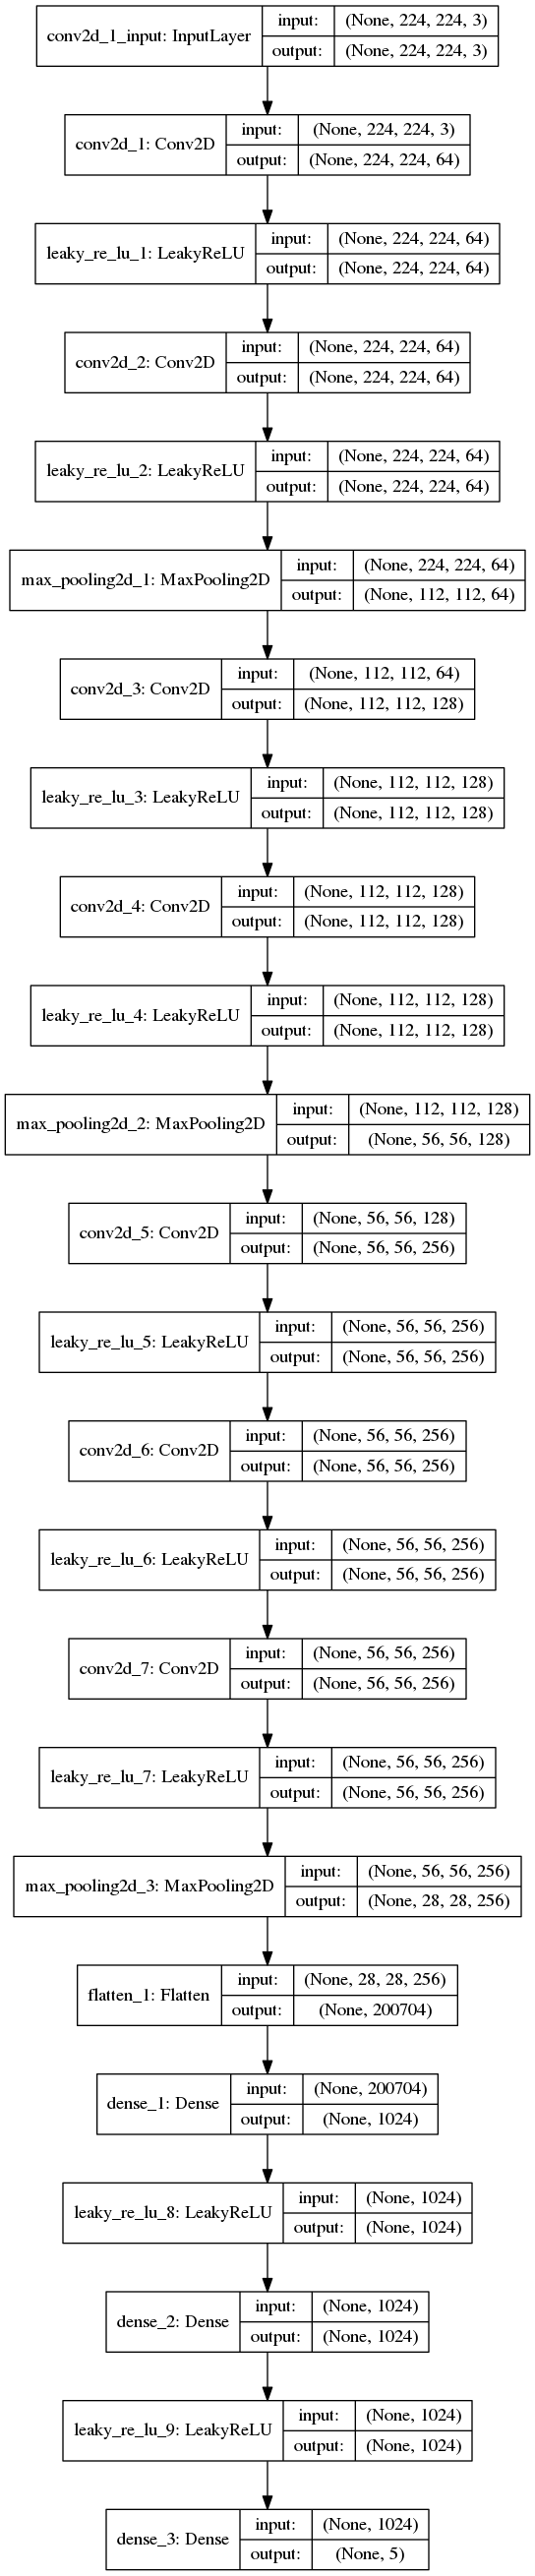

In [7]:
import keras
from keras.models import Sequential
from keras.layers import Dense, Activation, Dropout, Flatten, BatchNormalization, LeakyReLU
from keras.layers import Conv2D
from keras.layers import MaxPooling2D
from keras.utils import plot_model

# creating the actual model using the VGGNet16 architecture

input_shape = (IMG_SIZE, IMG_SIZE, 3) # 224x224x3 RGB image

#Instantiate an empty model
model = Sequential([
Conv2D(64, (3, 3), input_shape=input_shape, kernel_initializer='glorot_normal', bias_initializer='zeros', padding='same'), # first two convolutional layers
LeakyReLU(alpha=0.01),
Conv2D(64, (3, 3), padding='same'),
LeakyReLU(alpha=0.01),
MaxPooling2D(pool_size=(2, 2), strides=(2, 2)),
Conv2D(128, (3, 3), padding='same'), 
LeakyReLU(alpha=0.01),
Conv2D(128, (3, 3), padding='same',), 
LeakyReLU(alpha=0.01),
MaxPooling2D(pool_size=(2, 2), strides=(2, 2)),
Conv2D(256, (3, 3), padding='same',),
LeakyReLU(alpha=0.01),
Conv2D(256, (3, 3), padding='same',),
LeakyReLU(alpha=0.01),
Conv2D(256, (3, 3), padding='same',),
LeakyReLU(alpha=0.01),
MaxPooling2D(pool_size=(2, 2), strides=(2, 2)), 
Flatten(), 
Dense(1024), # fully connected layers
LeakyReLU(alpha=0.01),
Dense(1024),
LeakyReLU(alpha=0.01),
Dense(5, activation='softmax') # softmax output layer, 5 possible values/classes
])

model.summary()

plot_model(model, show_shapes=True, to_file='vgg_block.png')

# Training

In [8]:
# compiling model and training
from keras.callbacks import ModelCheckpoint

#opt = optimizers.SGD(lr=LEARN_RATE, momentum=.9) # momentum help accelerate gradient vectors in the right directions
opt = optimizers.Adam(lr=LEARN_RATE)

model.compile(loss="categorical_crossentropy",
              optimizer=opt,
              metrics=['accuracy'])
'''


# Compile the model
model.compile(loss="categorical_crossentropy", optimizer='SGD', metrics=['accuracy'])
'''
print(X_train.shape)
print(y_train.shape)

'''
# fitting model without image augmentation
model.fit(X_train, 
          y_train, 
          batch_size=BATCH_SZ, 
          epochs=EPOCHS,     
          validation_data=(X_valid, y_valid))
'''
checkpointer = ModelCheckpoint(filepath='/home/jupyter/weights.{epoch:02d}-{val_loss:.2f}.hdf5', verbose=1, save_best_only=True)

# fitting model with image augmentation
history = model.fit_generator(datagener,
                    steps_per_epoch=X_train.shape[0] // BATCH_SZ,
                    epochs=EPOCHS,
                    validation_data=vdatagener,
                    shuffle=True,
                    callbacks=[checkpointer])

(3750, 224, 224, 3)
(3750, 5)
Epoch 1/40
58/58 [==============================] - 1079s 19s/step - loss: 21.5217 - accuracy: 0.2230 - val_loss: 1.5011 - val_accuracy: 0.3006

Epoch 00001: val_loss improved from inf to 1.50109, saving model to /home/jupyter/weights.01-1.50.hdf5


/usr/local/lib/python3.5/dist-packages/keras/engine/saving.py:165: UserWarning: TensorFlow optimizers do not make it possible to access optimizer attributes or optimizer state after instantiation. As a result, we cannot save the optimizer as part of the model save file.You will have to compile your model again after loading it. Prefer using a Keras optimizer instead (see keras.io/optimizers).
  'TensorFlow optimizers do not '


Epoch 2/40
58/58 [==============================] - 1078s 19s/step - loss: 1.4510 - accuracy: 0.3611 - val_loss: 1.4863 - val_accuracy: 0.3474

Epoch 00002: val_loss improved from 1.50109 to 1.48627, saving model to /home/jupyter/weights.02-1.49.hdf5
Epoch 3/40
58/58 [==============================] - 1090s 19s/step - loss: 1.3737 - accuracy: 0.4162 - val_loss: 1.2861 - val_accuracy: 0.4217

Epoch 00003: val_loss improved from 1.48627 to 1.28608, saving model to /home/jupyter/weights.03-1.29.hdf5
Epoch 4/40
58/58 [==============================] - 1092s 19s/step - loss: 1.3313 - accuracy: 0.4495 - val_loss: 1.5073 - val_accuracy: 0.2971

Epoch 00004: val_loss did not improve from 1.28608
Epoch 5/40
58/58 [==============================] - 1083s 19s/step - loss: 1.3485 - accuracy: 0.4278 - val_loss: 1.3195 - val_accuracy: 0.4491

Epoch 00005: val_loss did not improve from 1.28608
Epoch 6/40
58/58 [==============================] - 1086s 19s/step - loss: 1.3079 - accuracy: 0.4449 - val_l

# Data Visualization: Accuracy & Loss

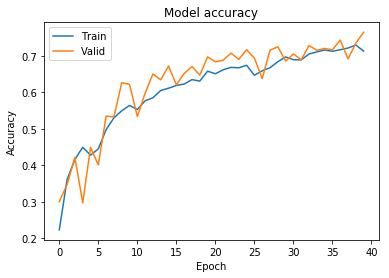

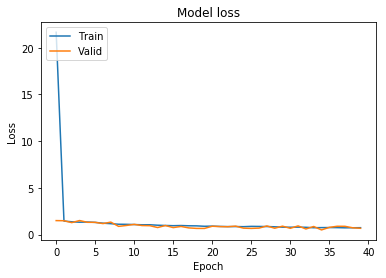

In [17]:
# Plot training & validation accuracy values
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('Model accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(['Train', 'Valid'], loc='upper left')
plt.show()

# Plot training & validation loss values
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('Model loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['Train', 'Valid'], loc='upper left')
plt.show()

# Evaluation

In [13]:
# image augmentation - for better performance
tdatagen = ImageDataGenerator()

tdatagener = vdatagen.flow(X_test, y_test, batch_size = BATCH_SZ, shuffle=False)
tdatagen.fit(X_test)

scores = model.evaluate_generator(tdatagener, verbose=1)
print('Test Loss: ', scores[0])
print('Test Accuracy: ', scores[1])

6/6 [==============================] - 33s 5s/step
Test Loss:  0.6059923768043518
Test Accuracy:  0.7519999742507935


In [14]:
import matplotlib.pyplot as plt
tdatagener.reset()
tdatagen.fit(X_test)

predictions = model.predict_generator(tdatagener)

In [15]:
pred_classes = predictions.argmax(axis=-1)

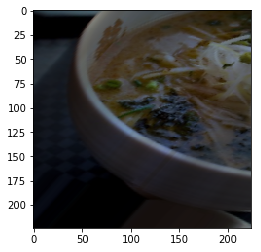

NameError: name 'x' is not defined

In [16]:
count_correct = 0
total = len(X_test)

count_pred = 0
for (a,b) in tdatagener:
    for i in range(0, BATCH_SZ):
        img = a[i].astype('uint32')
        plt.imshow(img, cmap=plt.get_cmap('gray'))
        plt.show()
        print(x)
        
        pred = noodle_classes[pred_classes[count_pred]]
        actual = noodle_classes[b[i].argmax(axis=-1)]
        
        print("Predicted Class: ", pred)
        #print("Prediction index: ", x.index(max(x)))
        print("Actual Class: ", actual)
        if (pred == actual):
            print("CORRECT")
            count_correct += 1
        count_pred += 1
        
print("SUMMARY")
print("Number correct: ", count_correct)
print("Percent correct: ", count_correct/ total)

In [ ]:
# Keeping track of overall results
import pandas as pd

print("Before Image Augmentation:")
data = [[30, 32, 0.0001, 1.6084, 0.4133],
        [40, 64, 0.0001, 1.6089, 0.2987]]
pd.DataFrame(data, columns=["Epochs", "Batch Size", "Learning Rate", "Test Loss", "Test Accuracy"])

# Test Group for Comparison with SVM & AlexNet

In [59]:
X_test_group, y_test_group = create_data('test_group', "test")

pad_thai 0
pho 1
ramen 2
spaghetti_bolognese 3
spaghetti_carbonara 4
X (25, 224, 224, 3)
y (25, 1)


In [60]:
X_test_group = tf.keras.utils.normalize(X_test_group, axis=1)
y_test_group = tf.keras.utils.to_categorical(y_test_group, NUM_CLASSES)

In [61]:
# image augmentation - for better performance
tgroup_datagen = ImageDataGenerator()

tgroup_datagener = vdatagen.flow(X_test_group, y_test_group, batch_size = BATCH_SZ, shuffle=False)
tgroup_datagen.fit(X_test_group)

scores = model.evaluate_generator(tgroup_datagener, verbose=1)
print('Test Group Loss: ', scores[0])
print('Test Group Accuracy: ', scores[1])

1/1 [==============================] - 3s 3s/step
Test Group Loss:  0.26719382405281067
Test Group Accuracy:  0.9599999785423279


In [62]:
import matplotlib.pyplot as plt
tgroup_datagener.reset()
tgroup_datagen.fit(X_test)

predictions = model.predict_generator(tgroup_datagener)

In [63]:
pred_classes = predictions.argmax(axis=-1)

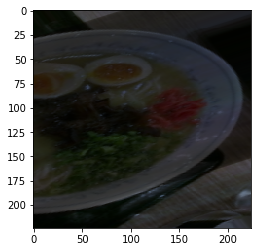

Predicted Class:  ramen
Actual Class:  ramen
CORRECT


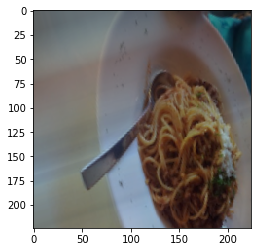

Predicted Class:  spaghetti_bolognese
Actual Class:  spaghetti_bolognese
CORRECT


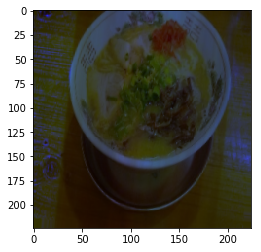

Predicted Class:  ramen
Actual Class:  ramen
CORRECT


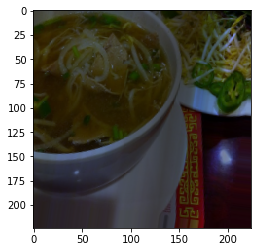

Predicted Class:  pho
Actual Class:  pho
CORRECT


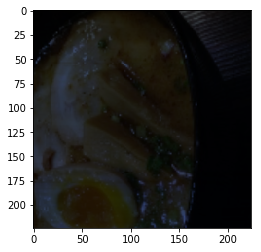

Predicted Class:  ramen
Actual Class:  ramen
CORRECT


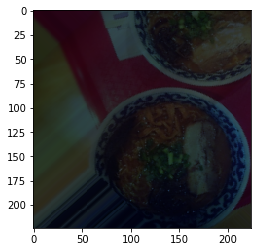

Predicted Class:  pho
Actual Class:  ramen


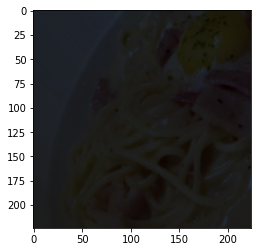

Predicted Class:  spaghetti_carbonara
Actual Class:  spaghetti_carbonara
CORRECT


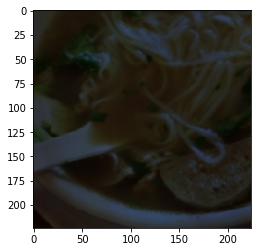

Predicted Class:  pho
Actual Class:  pho
CORRECT


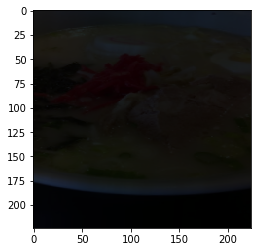

Predicted Class:  ramen
Actual Class:  ramen
CORRECT


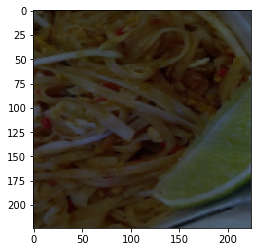

Predicted Class:  pad_thai
Actual Class:  pad_thai
CORRECT


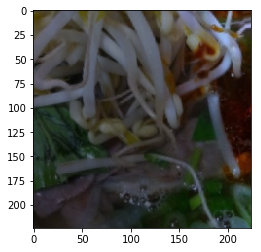

Predicted Class:  pho
Actual Class:  pho
CORRECT


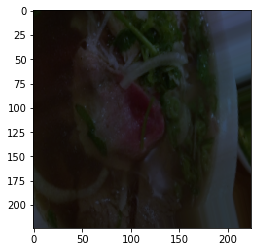

Predicted Class:  pho
Actual Class:  pho
CORRECT


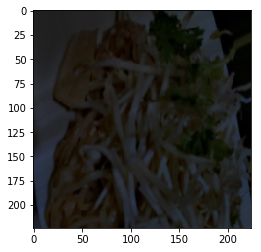

Predicted Class:  spaghetti_carbonara
Actual Class:  pad_thai


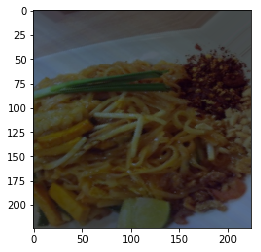

Predicted Class:  pad_thai
Actual Class:  pad_thai
CORRECT


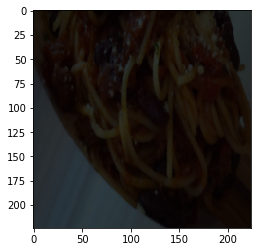

Predicted Class:  spaghetti_bolognese
Actual Class:  spaghetti_bolognese
CORRECT


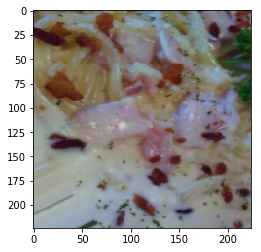

Predicted Class:  spaghetti_carbonara
Actual Class:  spaghetti_carbonara
CORRECT


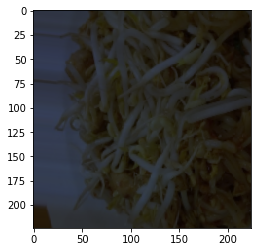

Predicted Class:  spaghetti_carbonara
Actual Class:  pad_thai


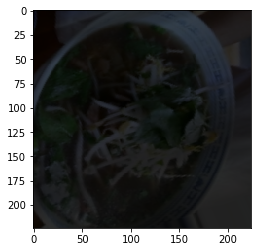

Predicted Class:  pho
Actual Class:  pho
CORRECT


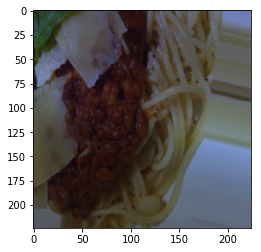

Predicted Class:  spaghetti_bolognese
Actual Class:  spaghetti_bolognese
CORRECT


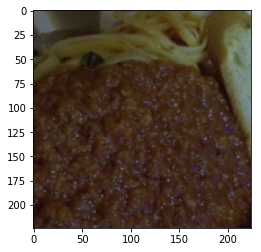

Predicted Class:  spaghetti_bolognese
Actual Class:  spaghetti_bolognese
CORRECT


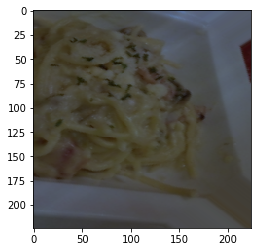

Predicted Class:  spaghetti_carbonara
Actual Class:  spaghetti_carbonara
CORRECT


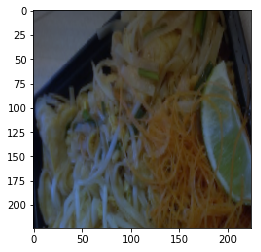

Predicted Class:  pad_thai
Actual Class:  pad_thai
CORRECT


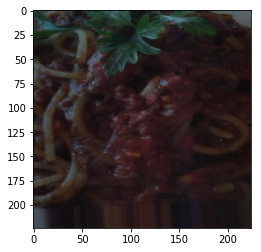

Predicted Class:  spaghetti_bolognese
Actual Class:  spaghetti_bolognese
CORRECT


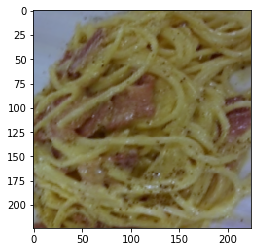

Predicted Class:  spaghetti_carbonara
Actual Class:  spaghetti_carbonara
CORRECT


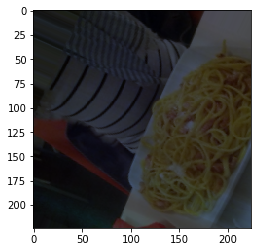

Predicted Class:  spaghetti_carbonara
Actual Class:  spaghetti_carbonara
CORRECT


IndexError: index 25 is out of bounds for axis 0 with size 25

In [64]:
count_correct = 0
total = len(X_test_group)

count_pred = 0
for (a,b) in tgroup_datagener:
    for i in range(0,BATCH_SZ):
        img = a[i].astype('uint32')
        plt.imshow(img, cmap=plt.get_cmap('gray'))
        plt.show()
#        print(x)

        pred = noodle_classes[pred_classes[count_pred]]
        actual = noodle_classes[b[i].argmax(axis=-1)]

        print("Predicted Class: ", pred)
        #print("Prediction index: ", x.index(max(x)))
        print("Actual Class: ", actual)
        if (pred == actual):
            print("CORRECT")
            count_correct += 1
        count_pred += 1

print("SUMMARY")
print("Number correct: ", count_correct)
print("Percent correct: ", count_correct/ total)

Note: Could not figure out why I am still getting the IndexError in the above cell, but it is printing all 25 images and counting the number of correct predictions so I am able to show that below:

In [65]:
print("SUMMARY")
print("Number correct: ", count_correct)
print("Percent correct: ", count_correct/ 25)

SUMMARY
Number correct:  22
Percent correct:  0.88


In [30]:
# Flo's code
scores = model.predict_classes(X_test_group, verbose=2)
print(scores)
num_classes = len(scores)
score = 0
for i in range(num_classes):
    actual = noodle_classes[np.argmax(y_test_group[i],axis=0)]
    #print(actual)
    #index_of_predicted_class = np.argmax(scores[i],axis=0)
    index_of_predicted_class = scores[i]
    #print(index_of_predicted_class)
    pred = noodle_classes[index_of_predicted_class]
    #acc = np.round(scores[i][index_of_predicted_class],2)
    print("\npred:",pred)
    if( pred == actual ):
        print("+1")
        score += 1
    else:
         print("actual:",actual)
    print(score,"out of",num_classes)

[2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2]

pred: ramen
actual: pho
0 out of 25

pred: ramen
actual: spaghetti_carbonara
0 out of 25

pred: ramen
actual: spaghetti_carbonara
0 out of 25

pred: ramen
actual: pho
0 out of 25

pred: ramen
actual: pho
0 out of 25

pred: ramen
actual: spaghetti_bolognese
0 out of 25

pred: ramen
actual: pho
0 out of 25

pred: ramen
actual: spaghetti_bolognese
0 out of 25

pred: ramen
actual: pad_thai
0 out of 25

pred: ramen
actual: spaghetti_bolognese
0 out of 25

pred: ramen
actual: pad_thai
0 out of 25

pred: ramen
+1
1 out of 25

pred: ramen
actual: spaghetti_carbonara
1 out of 25

pred: ramen
actual: spaghetti_carbonara
1 out of 25

pred: ramen
+1
2 out of 25

pred: ramen
actual: pad_thai
2 out of 25

pred: ramen
actual: spaghetti_bolognese
2 out of 25

pred: ramen
+1
3 out of 25

pred: ramen
actual: spaghetti_bolognese
3 out of 25

pred: ramen
actual: spaghetti_carbonara
3 out of 25

pred: ramen
actual: pad_thai
3 out of 25

pred: ramen
+1
4 